# Pitch recognition from speech
Feature extraction using CNN on raw audio files
<br> Train baseline LogReg model
<br> Train SVM model


In [1]:
import rarfile
import random
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio
import pickle
from tqdm import tqdm

import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import random_split
import torch.optim as optim
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading and Visualizing random Audio File

In [4]:
# QC
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Wave"
all_files = list(Path(dataset_dir).rglob("*.wav"))
print(len(all_files))  # raw count

12660


In [5]:
# play audio file
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations"
datatype = "Wave"
targets = ["Statements", "Questions", "Exclamations"]
target = random.choice(targets)
person = str(random.randint(1, 10)) 
person_dir = os.path.join(dataset_dir, datatype, target, person)

wav_files = [f for f in os.listdir(person_dir) if f.lower().endswith(".wav")]
wav_file = random.choice(wav_files)
print(target, wav_file)
wav_path = os.path.join(person_dir, wav_file)

audio_signal, sample_rate = librosa.load(wav_path, sr=None)
Audio(wav_path)

Exclamations 0EF117.wav


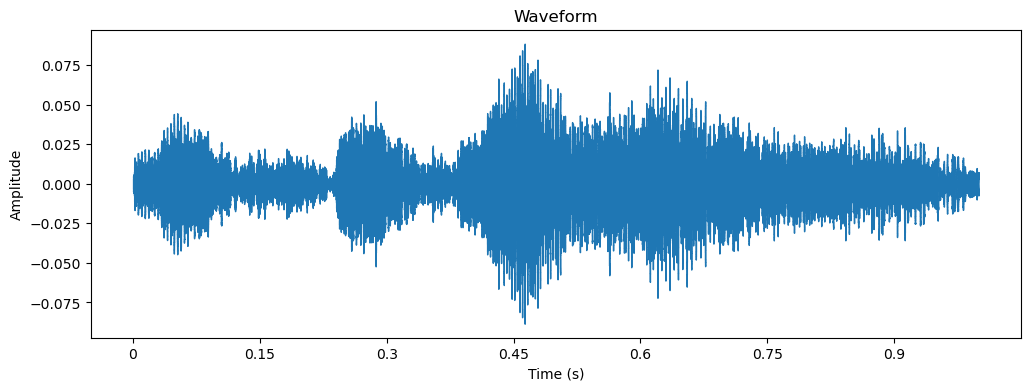

In [6]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_signal, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Read audio signals for feature extraction

In [7]:
# QC
# 12660
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Raw Data"
all_files = list(Path(dataset_dir).rglob("*.ogg"))
print(len(all_files))  # raw count

12660


In [8]:
class MFCCDataset(Dataset):
    def __init__(self, dataset_dir, targets, n_mfcc=40, max_len=200):
        self.samples = []
        self.labels = []
        self.fnames = []
        self.n_mfcc = n_mfcc
        self.max_len = max_len

        for label, target in enumerate(targets):
            target_dir = os.path.join(dataset_dir, target)
            for root, _, files in os.walk(target_dir):
                for fname in files:
                    if not fname.endswith(".ogg"):
                        continue
                    fpath = os.path.join(root, fname)

                    try:
                        y, sr = librosa.load(fpath, sr=None)
                        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

                        # pad or truncate to fixed length
                        if mfcc.shape[1] < max_len:
                            pad_width = max_len - mfcc.shape[1]
                            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                        else:
                            mfcc = mfcc[:, :max_len]

                        self.samples.append(mfcc)
                        self.labels.append(label)
                        self.fnames.append(fname)
                    except Exception as e:
                        print(f"Skipping {fpath}: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.tensor(self.samples[idx], dtype=torch.float32).unsqueeze(0)  # (1, n_mfcc, max_len)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y, self.fnames[idx]
        

In [9]:
class CNNEncoder(nn.Module):
    '''
    Basic 2 layers CNN.
    '''
    def __init__(self, n_mfcc=40, embedding_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        # calculate size after pooling
        dummy = torch.zeros(1, 1, n_mfcc, 200)  # (batch, channel, n_mfcc, max_len)
        with torch.no_grad():
            out = self.conv(dummy)
            flatten_dim = out.view(1, -1).shape[1]

        self.fc = nn.Linear(flatten_dim, embedding_dim)

    def forward(self, x):
        x = self.conv(x)           # (batch, channels, h, w)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)             # embedding
        return x
        

In [9]:
# Deep CNN + training 
class DeepCNN(nn.Module):
    def __init__(self, n_mfcc=40, embedding_dim=128, n_classes=3, dropout=0.3):
        """
        A deeper CNN that returns (embedding, logits). Uses AdaptiveAvgPool2d
        so it adapts to different time-dimensions (max_len).
        """
        super().__init__()
        # conv block helper
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
            )

        self.layer1 = conv_block(1, 32)    # input: (1, n_mfcc, time)
        self.layer2 = conv_block(32, 64)
        self.layer3 = conv_block(64, 128)
        # final conv to compress channels, then global pooling
        self.conv_final = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))  # -> (batch, 256, 1, 1)
        )
        self.flatten_dim = 256
        self.fc_embed = nn.Linear(self.flatten_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(embedding_dim, n_classes)

        # weight init
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if getattr(m, "bias", None) is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # x shape: (B, 1, n_mfcc, time)
        x = self.layer1(x)   # downsample 2x
        x = self.layer2(x)   # downsample 2x
        x = self.layer3(x)   # downsample 2x
        x = self.conv_final(x)  # (B, 256, 1,1)
        x = x.view(x.size(0), -1)  # (B, 256)
        emb = self.fc_embed(x)     # (B, embedding_dim)
        emb_d = self.dropout(emb)
        logits = self.classifier(emb_d)
        return emb, logits

def train_deepcnn(dataset, model,
                  epochs=20, batch_size=32, lr=1e-3, weight_decay=1e-5,
                  val_size=0.2, random_state=42, device=None, save_path=None):
    """
    Train the DeepCNN as a supervised classifier; returns best_model (weights).
    dataset must be an instance of MFCCDataset (with .labels list accessible).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Stratified split indices so classes are balanced
    labels = np.array(dataset.labels)
    idx = np.arange(len(dataset))
    train_idx, val_idx = train_test_split(idx, test_size=val_size, stratify=labels, random_state=random_state)

    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, epochs+1):
        # Training per epoch
        model.train()
        running_loss = 0.0
        for batch_x, batch_y, _ in tqdm(train_loader, desc=f"Train E{epoch}", leave=False):
            batch_x = batch_x.to(device)    # (B,1,n_mfcc,max_len)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            _, logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_x.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y, _ in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                _, logits = model(batch_x)
                loss = criterion(logits, batch_y)
                val_loss += loss.item() * batch_x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == batch_y).sum().item()
                total += batch_x.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        print(f"Epoch {epoch:02d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

        # save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            if save_path:
                torch.save(best_state, save_path)

    # load best state into model
    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    return model


In [11]:
# %%time
# dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Raw Data"
# targets=["Statements", "Questions", "Exclamations"]

# dataset = MFCCDataset(dataset_dir, targets, n_mfcc=40, max_len=200)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# # test simple CNN
# encoder = CNNEncoder(n_mfcc=40, embedding_dim=128)
# encoder.eval()

# all_embeddings, all_labels, all_files = [], [], []

# with torch.no_grad():
#     for batch_x, batch_y, batch_fnames in tqdm(dataloader, desc="Extracting embeddings"):
#         embeddings = encoder(batch_x)
#         all_embeddings.append(embeddings.numpy())
#         all_labels.append(batch_y.numpy())
#         all_files.extend(batch_fnames)

# X = np.vstack(all_embeddings)
# y = np.hstack(all_labels)

# save_path = os.path.join(dataset_dir, "mfcc_embeddings.pkl")

# joblib.dump((X, y), "mfcc_embeddings.pkl")

# print(f"Saved embeddings to {save_path}")
# print(f"Shape: X={X.shape}, y={y.shape}")


In [1]:
%%time
dataset_dir = r"C:\Users\USER\Documents\...\Statements, Questions, and Exclamations\Raw Data"
targets=["Statements", "Questions", "Exclamations"]

dataset = MFCCDataset(dataset_dir, targets, n_mfcc=40, max_len=200)

# use CNN with more layers
model = DeepCNN(n_mfcc=40, embedding_dim=128, n_classes=len(targets))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = train_deepcnn(dataset, model, epochs=15, batch_size=32, lr=1e-3,
                              weight_decay=1e-5, val_size=0.2, random_state=42,
                              device=device, save_path="best_deepcnn.pth")

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
trained_model = trained_model.to(device)
trained_model.eval()

all_embs, all_labels, all_files = [], [], []
with torch.no_grad():
    for batch_x, batch_y, batch_fnames in tqdm(dataloader, desc="Extracting embeddings"):
        batch_x = batch_x.to(device)
        emb, _ = trained_model(batch_x)
        all_embs.append(emb.cpu().numpy())
        all_labels.append(batch_y.numpy())
        all_files.extend(batch_fnames)

X = np.vstack(all_embs)
y = np.hstack(all_labels)

save_path = os.path.join(dataset_dir, "mfcc_deepcnn_embeddings.pkl")

joblib.dump((X, y), "mfcc_deepcnn_embeddings.pkl")

print(f"Saved embeddings to {save_path}")
print(f"Shape: X={X.shape}, y={y.shape}")


**load file if already saved**

In [14]:
# load embeddings (if previously saved)
X, y = joblib.load("mfcc_embeddings.pkl")
# X, y = joblib.load("mfcc_deepcnn_embeddings.pkl")

print(f"Shape: X={X.shape}, y={y.shape}")

Shape: X=(12660, 128), y=(12660,)


In [15]:
# See first few rows of X
# print("First 5 embeddings:\n", X[:5])

# See first few labels
# print("First 20 labels:\n", y[:5])
print("Unique labels in y:", np.unique(y))

Unique labels in y: [0 1 2]


## Model training

### Logistic Regression (baseline)

In [16]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.001)), 
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, n_jobs=-1))
])

search_spaces = {
    'logreg__C': Real(10, 1e2, prior='log-uniform'),
    'logreg__penalty': Categorical(['l2']),
    'logreg__solver': Categorical(['saga'])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_spaces,
    n_iter=10,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train)

y_pred = opt.predict(X_test)
print("Best hyperparameters:", opt.best_params_)
print("CV accuracy:", opt.best_score_)
print("Holdout accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: OrderedDict([('logreg__C', 25.71011142608906), ('logreg__penalty', 'l2'), ('logreg__solver', 'saga')])
CV accuracy: 0.590935712283524
Holdout accuracy: 0.5947867298578199
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.65      0.62       847
           1       0.62      0.59      0.60       845
           2       0.57      0.55      0.56       840

    accuracy                           0.59      2532
   macro avg       0.59      0.59      0.59      2532
weighted avg       0.60      0.59      0.59      2532

CPU times: total: 5.05 s
Wall time: 2min 3s


### SVM

In [17]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.001)),
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

search_spaces = {
    'svm__C': Real(1, 100, prior='log-uniform'),        # 1 to 100
    'svm__gamma': Real(0.1, 1, prior='log-uniform'),    # 0.1 to 1
    'svm__kernel': Categorical(['rbf', 'poly'])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_spaces,
    n_iter=10,              
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

opt.fit(X_train, y_train)

y_pred = opt.predict(X_test)
print("Best hyperparameters:", opt.best_params_)
print("CV accuracy:", opt.best_score_)
print("Holdout accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: OrderedDict([('svm__C', 6.61009829541915), ('svm__gamma', 0.5342268887471111), ('svm__kernel', 'poly')])
CV accuracy: 0.6506714928156192
Holdout accuracy: 0.6394154818325435
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.69      0.67       847
           1       0.65      0.62      0.64       845
           2       0.62      0.61      0.61       840

    accuracy                           0.64      2532
   macro avg       0.64      0.64      0.64      2532
weighted avg       0.64      0.64      0.64      2532

CPU times: total: 3min 14s
Wall time: 33min 49s


NOTE: 
- MFCCs capture timbre/phonetic envelope, which is very useful for speech recognition
- but they lose pitch/intonation information, which is exactly what distinguishes statements vs. questions vs. exclamations.
- So MFCCs alone might not be the right feature set for this problem.
- One can also augment dataset by:
- (1) add prosodic features:
<br> Pitch (F0 contour)
<br> Energy/loudness
<br> Duration features (e.g., length of utterance, pause distribution)
- (2) use pretrained audio embeddings
<br> Wav2Vec2.0 (Facebook AI)
<br> YAMNet (Google, based on AudioSet, outputs 1024-d embeddings)
<br> HuBERT
